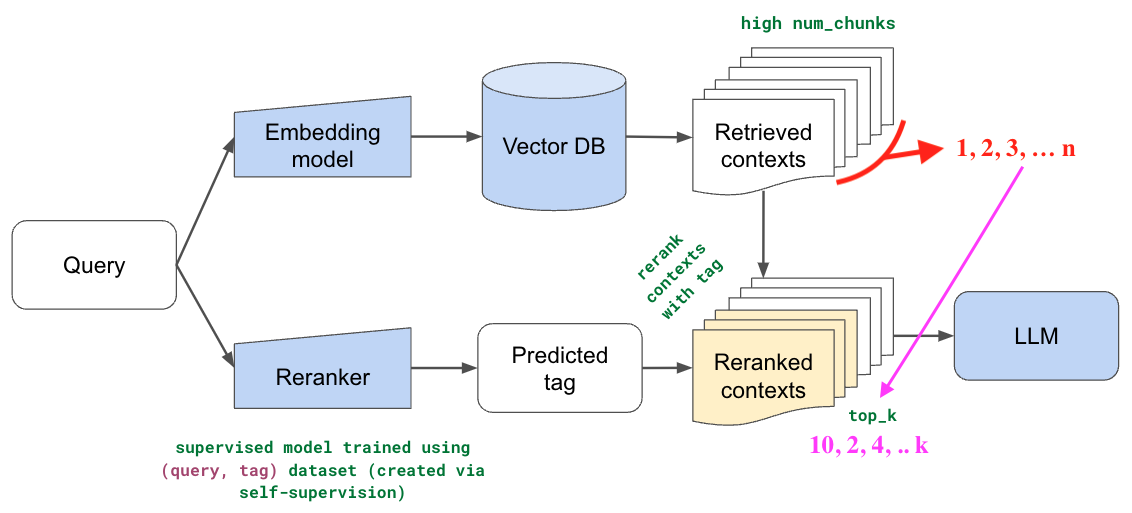

# Problem Statement:


In a typical RAG pipeline, LLM Context window is limited so for a hypothetical 10000 pages document, we need to chunk the document. For any incoming user query, we need to fetch `Top-N` related chunks and because neither our Embedding are 100% accurate nor search algo is perfect, it could give us unrelated results too. This is a flaw in RAG pipeline. How can you deal with it? If you fetch Top-1 and the context is different then it's a sure bad answer. On the other hand, if you fetch more chunks and pass to LLM, it'll get confused and with higher number, it'll go out of context.

# What's the remedy?

Out of all the methods available, Re-ranking is the simplest. Idea is pretty simple.


1. You assume that Embedding + Search algo are not 100% precise so you use Recall to your advantage and get similar high `N` (say 25) number of related chunks from corpus.

2. Second step is to use a powerful model to increase the Precision. You re-rank above `N` queries again so that you can change the relative ordering and now select Top `K` queries (say 3) to pass as a context where `K` < `N` thus increasing the Precision.


# Why can't you use the bigger model in the first place?
Would your search results be better if you were searching in 100 vs 100000 documents? Yes, so no matter how big of a model you use, you'll always have some irrelevent results because of the huge domain.


Smaller model with efficient searching algo does the work of searching in a bigger domain to get more number of elements while the larger model is precise and because it just works on `K`, there is a bit more overhead but improved relevancy.


## Credentials

Copy and paste the project name and the api key from your project page.
These will be used later to [connect to LanceDB Cloud](#scroll-to=5q8m6GMD7sGu)

In [1]:
project_slug = "your-project-slug" # @param {type:"string"}

In [2]:
api_key = "sk_..." # @param {type:"string"}

You can also set the LANCEDB_API_KEY as an environment variable with one of the options below

In [ ]:
!export LANCEDB_API_KEY="sk_..."

In [ ]:
import os
import getpass
os.environ["LANCEDB_API_KEY"] = getpass.getpass("Enter Your LANCEDB API Key:")

### Installing dependencies

In [3]:
!pip install -U lancedb transformers datasets FlagEmbedding unstructured langchain -qq

# NOTE: If there is an import error, restart and run the notebook again

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 30.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.6/803.6 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.1 M

### Importing libraries

In [4]:
from FlagEmbedding import LLMEmbedder, FlagReranker # Al document present here https://github.com/FlagOpen/FlagEmbedding/tree/master
import os
import lancedb
import re
import pandas as pd
import random

from datasets import load_dataset

import torch
import gc

from lancedb.embeddings import with_embeddings


task = "qa" # Encode for a specific task (qa, icl, chat, lrlm, tool, convsearch)
embed_model = LLMEmbedder('BAAI/llm-embedder', use_fp16=False) # Load model (automatically use GPUs)

reranker_model = FlagReranker('BAAI/bge-reranker-base', use_fp16=True) # use_fp16 speeds up computation with a slight performance degradation

# For basic splitting
# basic_text_splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=64,) # 512 is the default Embedding model max_len

# For Advanced Usage: https://python.langchain.com/docs/modules/data_connection/document_transformers/text_splitters/split_by_token
# embedder_tokenizer = AutoTokenizer.from_pretrained("BAAI/llm-embedder") # Advanced Tokenizer Splitter Strategy
# advanced_text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(embedder_tokenizer, chunk_size=512, chunk_overlap=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

# Load `Chunks` of data from [BeIR Dataset](https://huggingface.co/datasets/BeIR/scidocs)

Note: This is a dataset built specially for retrieval tasks to see how good your search is working

In [5]:
queries = load_dataset("BeIR/scidocs", "queries")["queries"].to_pandas()
docs = load_dataset('BeIR/scidocs', 'corpus')["corpus"].to_pandas().dropna(subset = "text").sample(10000) # just random samples for faster embed demo
docs.sample(3)

Generating queries split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating corpus split:   0%|          | 0/25657 [00:00<?, ? examples/s]

,_id,title,text
13181,6df3dc585e32f3b1cb49228d94a5469c30d79d2b,High Performance Computer Acoustic Data Accele...,This paper presents a new software model desig...
18678,784376563c94e231241fbcf71d4d2774aec4b935,A Comparison over Focused Web Crawling Strategies,In this paper we review and compare focused cr...
4444,19751e0f81a103658bbac2506f5d5c8e06a1c06a,STDP-based spiking deep convolutional neural n...,Previous studies have shown that spike-timing-...


# Get embedding using [`LLM embedder`](https://github.com/FlagOpen/FlagEmbedding/tree/master/FlagEmbedding/llm_embedder) and create Database using [`LanceDB Cloud`](https://lancedb.github.io/lancedb/cloud/)

In [7]:
def embed_documents(batch):
    """
    Function to embed the whole text data
    """
    return embed_model.encode_keys(batch, task=task) # Encode data or 'keys'


uri = "db://" + project_slug
db = lancedb.connect(uri, api_key=api_key, region="us-east-1")
table_name = "doc_embed"
try:
    # Use the train text chunk data to save embed in the DB
  data = with_embeddings(embed_documents, docs, column = 'text',show_progress = True, batch_size = 128)
  table = db.create_table(table_name, data=data) # create Table
except:
  table = db.open_table(table_name) # Open Table



  0%|          | 0/79 [00:00<?, ?it/s]

# Search from a random Text

In [8]:
def search(query, top_k = 10):
  """
  Search a query from the table
  """
  query_vector = embed_model.encode_queries(query, task=task) # Encode the QUERY (it is done differently than the 'key')
  search_results = table.search(query_vector).limit(top_k)
  return search_results


query = random.choice(queries["text"])
print("QUERY:-> ", query)

# get top_k search results
search_results = search("what is mitochondria?", top_k = 10).to_pandas().dropna(subset = "text").reset_index(drop = True)

search_results

QUERY:->  Classification of human activity by using a Stacked Autoencoder


,_id,title,text,vector,_distance
0,83d323a5bb26b706d4f6d24eb27411a7e7ff57e6,Protective action of green tea catechins in ne...,Mitochondria are central players in the regula...,"[-0.014866754, 0.0028244434, -0.023141732, 0.0...",0.281554
1,a3345798b1faf238e8d805bbe9124b0b8e0c869f,Autophagy as a regulated pathway of cellular d...,Macroautophagy is a dynamic process involving ...,"[-0.042504933, 0.00053501845, -0.016986104, 0....",0.312909
2,e0534bfb477c5a82e98d0cb386ae3eb31d349c91,Cellular and molecular mechanisms of hepatocel...,Hepatocellular carcinoma (HCC) is the most com...,"[0.03984485, 0.01583628, -0.00934351, -0.02993...",0.366526
3,c65945c08b7fd77ffd2c53369e8928699c3993e7,Comparing Alzheimer’s and Parkinson’s diseases...,Recent advances in large datasets analysis off...,"[-0.004613025, -0.0044279257, -0.013920496, 0....",0.369777
4,1af2e075903a3cc5ad5a192921a0b4fb67645dc1,Mathematical models of cancer metabolism.,"Metabolism is essential for life, and its alte...","[-0.0037386382, 0.011562068, -0.022479024, 0.0...",0.370503
5,3979cf5a013063e98ad0caf2e7110c2686cf1640,Basic local alignment search tool.,"A new approach to rapid sequence comparison, b...","[-0.006935188, 0.020925103, -0.051218845, 0.00...",0.372769
6,0fb926cae217b70c97c74eb70b2a6b8c47574812,Network biology: understanding the cell's func...,A key aim of postgenomic biomedical research i...,"[0.012990677, 0.028128441, -0.006426807, -0.02...",0.376812
7,488257dcbc7bcb56836f10a410e69c2c283989e5,mTOR Signaling in Growth Control and Disease,The mechanistic target of rapamycin (mTOR) sig...,"[0.0006567143, 0.0053487234, -0.0010087299, -0...",0.376821
8,65f415c6d88aca139867702fc64aa179781b8e65,PID: the Pathway Interaction Database,"The Pathway Interaction Database (PID, http://...","[-0.007852315, 0.014019204, -0.026789214, -0.0...",0.378377
9,244fc78ce607812edb90290727dab4d33377e986,Transfer of mitochondria via tunneling nanotub...,Tunneling nanotubes (TNTs) are F-actin-based m...,"[-0.0063375738, 0.006348416, -0.034239322, 0.0...",0.380112


# Rerank Search Results using Reranker from [`BGE Reranker`](https://github.com/FlagOpen/FlagEmbedding/tree/master/FlagEmbedding/reranker)

Pass all the results to a stronger model to give them the similarity ranking

In [9]:
def rerank(query, search_results):
  search_results["old_similarity_rank"] = search_results.index+1 # Old ranks

  torch.cuda.empty_cache()
  gc.collect()

  search_results["new_scores"] = reranker_model.compute_score([[query,chunk] for chunk in search_results["text"]]) # Re compute ranks
  return search_results.sort_values(by = "new_scores", ascending = False).reset_index(drop = True)

print("QUERY:-> ", query)

rerank(query, search_results)

QUERY:->  Classification of human activity by using a Stacked Autoencoder


,_id,title,text,vector,_distance,old_similarity_rank,new_scores
0,a3345798b1faf238e8d805bbe9124b0b8e0c869f,Autophagy as a regulated pathway of cellular d...,Macroautophagy is a dynamic process involving ...,"[-0.042504933, 0.00053501845, -0.016986104, 0....",0.312909,2,-3.949219
1,3979cf5a013063e98ad0caf2e7110c2686cf1640,Basic local alignment search tool.,"A new approach to rapid sequence comparison, b...","[-0.006935188, 0.020925103, -0.051218845, 0.00...",0.372769,6,-5.410156
2,83d323a5bb26b706d4f6d24eb27411a7e7ff57e6,Protective action of green tea catechins in ne...,Mitochondria are central players in the regula...,"[-0.014866754, 0.0028244434, -0.023141732, 0.0...",0.281554,1,-6.652344
3,65f415c6d88aca139867702fc64aa179781b8e65,PID: the Pathway Interaction Database,"The Pathway Interaction Database (PID, http://...","[-0.007852315, 0.014019204, -0.026789214, -0.0...",0.378377,9,-7.402344
4,0fb926cae217b70c97c74eb70b2a6b8c47574812,Network biology: understanding the cell's func...,A key aim of postgenomic biomedical research i...,"[0.012990677, 0.028128441, -0.006426807, -0.02...",0.376812,7,-7.824219
5,1af2e075903a3cc5ad5a192921a0b4fb67645dc1,Mathematical models of cancer metabolism.,"Metabolism is essential for life, and its alte...","[-0.0037386382, 0.011562068, -0.022479024, 0.0...",0.370503,5,-8.070312
6,c65945c08b7fd77ffd2c53369e8928699c3993e7,Comparing Alzheimer’s and Parkinson’s diseases...,Recent advances in large datasets analysis off...,"[-0.004613025, -0.0044279257, -0.013920496, 0....",0.369777,4,-9.007812
7,488257dcbc7bcb56836f10a410e69c2c283989e5,mTOR Signaling in Growth Control and Disease,The mechanistic target of rapamycin (mTOR) sig...,"[0.0006567143, 0.0053487234, -0.0010087299, -0...",0.376821,8,-9.507812
8,244fc78ce607812edb90290727dab4d33377e986,Transfer of mitochondria via tunneling nanotub...,Tunneling nanotubes (TNTs) are F-actin-based m...,"[-0.0063375738, 0.006348416, -0.034239322, 0.0...",0.380112,10,-9.593750
9,e0534bfb477c5a82e98d0cb386ae3eb31d349c91,Cellular and molecular mechanisms of hepatocel...,Hepatocellular carcinoma (HCC) is the most com...,"[0.03984485, 0.01583628, -0.00934351, -0.02993...",0.366526,3,-10.195312
